In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torchvision import models, datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset

from PIL import Image

torch.cuda.is_available()
torch.cuda.get_device_name(0)
torch.cuda.set_device(0)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Setting the train and test paths so that data can be can be read. Manually analysing the file counts in the train folder it can been seen that images in the normal subfolder is lesser than the other three classes. This will be dealt with before training and evaluating the model**

In [2]:
train_path='../input/deep-learning-for-msc-coursework-2022/train/train'
test_path='../input/deep-learning-for-msc-coursework-2022/test'

**The values of mean and std for train and test transforms have been selected from the mean and standard deviation of ImageNet.Since ImageNet is trained on millions of pictures,I'll use the same parameters for my neural network**

In [3]:
train_transform = transforms.Compose([transforms.RandomVerticalFlip(p=0.7),
                                      transforms.RandomHorizontalFlip(p=0.7),
                                      transforms.ColorJitter(contrast=(0.43,1),brightness=(0.65,1),saturation=(0.73,1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                      ])

**Setting up the train dataset and applying the set of train transformations on each image in the folder**

In [4]:
fulldata=torchvision.datasets.ImageFolder(root=train_path,transform=train_transform)

**Splitting the data in a 80/20 split for training and evaluatiing the model**

In [5]:
trainsplit = int(len(fulldata)*(90/100))
testsplit = len(fulldata)- trainsplit

**Using random split function to divide the data into train and validation splits for training and evaluating the model**

In [6]:
trainset,valset = random_split(fulldata,(trainsplit,testsplit))

**Setting up training and validation dataloader to iterate through the items of the dataset in training and testing**

In [7]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=256,shuffle=True)
validloader=torch.utils.data.DataLoader(valset,batch_size=256,shuffle=True)

**Defining neural network for image classification, Here padding is set to 1 in covulutional layers to keep the image size same as it is passed through a convulutional layer**

In [8]:
class Covnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.drop=nn.Dropout(0.4)
        self.conv1=nn.Conv2d(3,512,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(1024,256,kernel_size=3,stride=1,padding=1)
        self.fc1=nn.Linear(16384,256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,4)
               
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = self.drop(X)
        X = F.relu(self.conv2(X))
        X = self.drop(X)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16384)
        X = F.relu(self.fc1(X))
        X = self.drop(X)
        X = F.relu(self.fc2(X))
        return self.fc3(X)

**Initializing the model and making it cuda compaitable so that GPU can be used for faster learning**

In [9]:
model = Covnet()
model = model.cuda()

**Checking if the model is set to cuda**

In [10]:
next(model.parameters()).is_cuda

True

**Releasing all unoccupied cache**

In [11]:
torch.cuda.empty_cache()

**Setting up loss function and optimizer for the neural network. Loss is given by CrossEntropyLoss and weights have been given to the function in the form of a tensor so that it can balance out label distribution. Maximum weights have been assigned to 'Normal' class and ADAM has been selected as the optimizer**

In [12]:
criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.2,1.04,1.3,2])).cuda()#Class weighting
optimizer = optim.Adam(model.parameters(), lr = 0.00001,weight_decay=0.01)

**Training and testing the initialized model with parameters**

In [13]:
epochs = 120

trainloss = []
valloss = []

train_acc_epochwise = []
val_acc_epochwise = []


#Setting a minimum loss value which can be surpassed and replaced by a new value if model produces lower loss
threshold = 15

#Looping over the entire train data in each epoch

for epoch in range(epochs):
    trainepoch = 0.0
    valepoch = 0.0
 #Training Loop
    for num, (X_train, y_train) in enumerate(trainloader):
        X_train, y_train=X_train.cuda(), y_train.cuda()
        trapred=model(X_train)
        loss=criterion(trapred,y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        c,d=torch.max(trapred.data,1)
        trainepoch+=int(torch.sum(d==y_train.data))
    train_acc_epochwise.append(trainepoch/trainsplit)    
    trainloss.append(loss.detach().cpu().numpy())  

    #Saving the best model when a model produces lower test loss than the previously set threshold
    if loss < threshold:
        torch.save(model.state_dict(),'bestomodelo.pth')
        threshold = loss
    
    #Predicting values in the validation set and checking the test accuracy
    with torch.no_grad():
        model.eval()
        for valnum, (X_test, y_test) in enumerate(validloader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            tespred = model(X_test)
            e,f=torch.max(tespred.data,1)
            valepoch+=int(torch.sum(f==y_test.data))
        val_acc_epochwise.append(valepoch/testsplit)
        model.train()  
    testloss = criterion(tespred,y_test) 
    valloss.append(testloss.detach().cpu().numpy())
    print(f'\n\nEpoch: {epoch+1} \nTrain_Accuracy: {trainepoch/trainsplit: .4f}\nTesting_Accuracy:{valepoch/testsplit: .4f}')




Epoch: 1 
Train_Accuracy:  0.3072
Testing_Accuracy: 0.2882


Epoch: 2 
Train_Accuracy:  0.2948
Testing_Accuracy: 0.2882


Epoch: 3 
Train_Accuracy:  0.2948
Testing_Accuracy: 0.2882


Epoch: 4 
Train_Accuracy:  0.2954
Testing_Accuracy: 0.2882


Epoch: 5 
Train_Accuracy:  0.3137
Testing_Accuracy: 0.3412


Epoch: 6 
Train_Accuracy:  0.3444
Testing_Accuracy: 0.4235


Epoch: 7 
Train_Accuracy:  0.4118
Testing_Accuracy: 0.4706


Epoch: 8 
Train_Accuracy:  0.4444
Testing_Accuracy: 0.5176


Epoch: 9 
Train_Accuracy:  0.4850
Testing_Accuracy: 0.6412


Epoch: 10 
Train_Accuracy:  0.5510
Testing_Accuracy: 0.6706


Epoch: 11 
Train_Accuracy:  0.6098
Testing_Accuracy: 0.6824


Epoch: 12 
Train_Accuracy:  0.6333
Testing_Accuracy: 0.6882


Epoch: 13 
Train_Accuracy:  0.6490
Testing_Accuracy: 0.6647


Epoch: 14 
Train_Accuracy:  0.6680
Testing_Accuracy: 0.6824


Epoch: 15 
Train_Accuracy:  0.6771
Testing_Accuracy: 0.7176


Epoch: 16 
Train_Accuracy:  0.6889
Testing_Accuracy: 0.6941


Epoch: 17 
Trai

**Evaluating the accuracy and loss of train and validation sets**

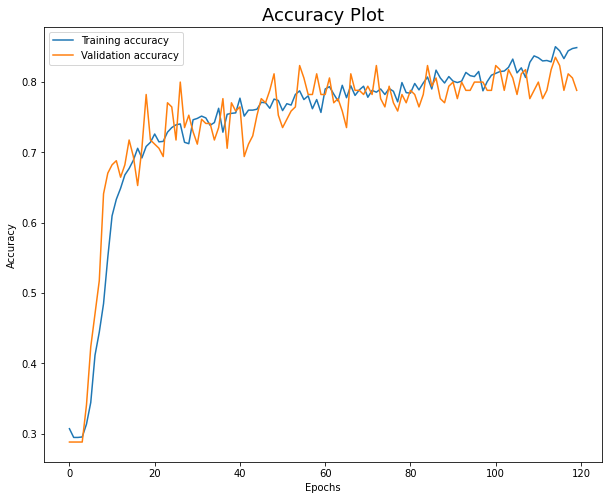

In [14]:
plt.figure(figsize=(10,8))
plt.plot(train_acc_epochwise,label='Training accuracy')
plt.plot(val_acc_epochwise,label='Validation accuracy')
plt.title('Accuracy Plot',fontsize=18)
plt.xlabel('Epochs',fontsize=10)
plt.ylabel('Accuracy',fontsize=10)
plt.legend()
plt.show()

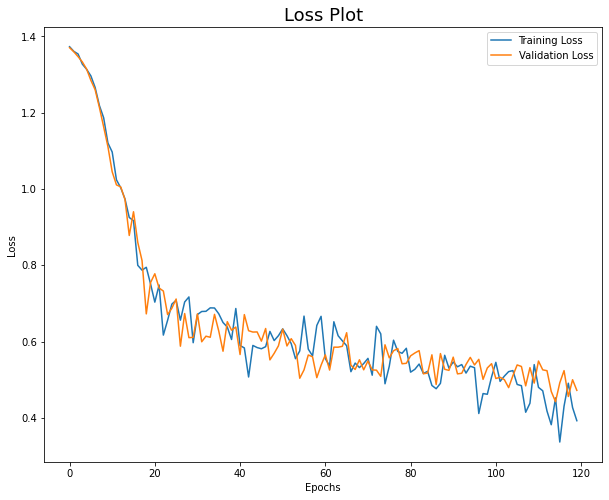

In [15]:
plt.figure(figsize=(10,8))
plt.plot(trainloss,label='Training Loss')
plt.plot(valloss,label='Validation Loss')
plt.title('Loss Plot',fontsize=18)
plt.xlabel('Epochs',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.legend()
plt.show()

**Getting the files from the test directory so that each of them can be predicted**

In [16]:
testroot=f'{test_path}/test'
filelist=os.listdir(testroot)

**Some Helperfunctions for transformation and prediction of test images**

In [17]:
#For transforming each individual image
def testtransformsperimg(x):
    x=transforms.functional.to_tensor(x)
    x=transforms.functional.normalize(x,[0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    return x

#For applying the transforms defined in testtransformsperimg function
def testimgtotransimg(x):
    imgfile = Image.open(f'{testroot}/{x}')
    return testtransformsperimg(imgfile)

#For getting the prediction of each image
def singleimagepred(model, tensor):
    img = torch.stack([tensor])
    softfun = nn.Softmax(dim = 1)
    return torch.argmax(softfun(model(img.cuda()).cuda())).item()

**Putting the model on eval mode and getting the prediction for each image**

In [18]:
model.cuda().load_state_dict(torch.load('bestomodelo.pth'))
model.cuda().eval()
predictdict = {imagefile: singleimagepred(model.cuda(),testimgtotransimg(imagefile)) for imagefile in filelist}

**Converting the obtained dictionary into a dataframe so that it can be easily converted into a csv file later**

In [19]:
predictserie = pd.Series({x:y for (x,y) in zip(predictdict.keys(), predictdict.values())})
predictdf = pd.DataFrame(predictserie, columns = ['Type']).sort_index()
predictdf['Id'] = predictdf.index
predictdf = predictdf[['Id', 'Type']]
predictdf.head()

,Id,Type
tile5001.png,tile5001.png,3
tile5002.png,tile5002.png,1
tile5003.png,tile5003.png,3
tile5004.png,tile5004.png,3
tile5005.png,tile5005.png,3


**Relablelling the numbers back to its actual class name**

In [20]:
def labelback(x):
    if x == 0 :
        return 'Cancer'
    if x == 1:
        return 'Connective'
    if x == 2:
        return 'Immune'
    if x == 3:
        return 'Normal'

In [21]:
predictdf['Type'] = predictdf['Type'].map(lambda x:labelback(x))

**Converting the dataframe to csv file**

In [22]:
predictdf.to_csv('submissions.csv',index=False)